In [1]:
import sys, os

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

### some convenient magics
%load_ext autoreload
%autoreload 2

In [2]:
lidardat = pd.read_csv('../../data/Lidar_timeseries.csv', 
                       header=None, 
                       names=['ua', 'ub'], 
                       delim_whitespace=True,
                      )
lidardat.index = 0.83*lidardat.index
lidardat.index.name = 'time'

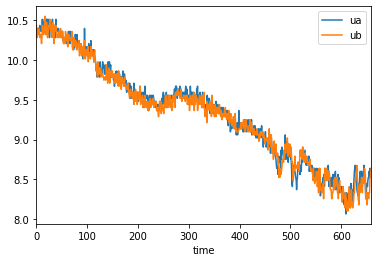

In [3]:
lidardat.plot()

In [4]:
# constants
fsamp = 0.83 # Hz
fvec = np.linspace(0, fsamp/2, 100) # frequency vector
dl = 36 # m separation distance

# pulsed lidar parameters
delp = 18.
delr = 49.8/2

In [5]:
U = lidardat.mean().mean()

In [53]:
def range_weight(delp,delr,res=1.,cutoff=0.01):
    rp = delr/(2*np.sqrt(np.log(2)))
    
    wts = np.array([(1/(2*delp))*(sp.special.erf((delp/2)/rp) - sp.special.erf((-delp/2)/rp))])
    wt = wts[0]
    wt0 = wt
    
    r = res
    while wt/wt0 > cutoff:
        wt = (1/(2*delp))*(sp.special.erf((r+delp/2)/rp) - sp.special.erf((r-delp/2)/rp))
        wts = np.append(np.append(wt,wts),wt)
        r = r + res
    
    wts = wts/np.sum(wts)
    
    return wts

def coh_fit(f, d, a, b):
    return np.exp( -a * np.sqrt( (f * d / U) ** 2.0 + (b * d) ** 2.0) )

def lidar_coh(f, a, b):
    res = 0.5
    wts = range_weight(delp,delr,res,0.01)
    xs = np.arange(-(len(wts)-1)*res/2,(len(wts)-1)*res/2+res,res)

    S_LL = np.zeros(len(f))
    S_L1L2 = np.zeros(len(f))

    # not including PSDs since they will cancel out in final coherence equation

    for i in range(len(xs)-1):
        for k in range(len(xs)-1):
            S_LL = S_LL + wts[i]*wts[k]*np.sqrt(coh_fit(f, np.abs(xs[k]-xs[i]), a, b))*np.exp(1j*2*np.pi*(xs[k]-xs[i])*f/U)
            S_L1L2 = S_L1L2 + wts[i]*wts[k]*np.sqrt(coh_fit(f, np.abs(dl+xs[k]-xs[i]), a, b))*np.exp(1j*2*np.pi*(dl+xs[k]-xs[i])*f/U)

    return (np.absolute(S_L1L2)**2)/(np.absolute(S_LL)**2)

def residual(p, f, y):
    return y - lidar_coh(f, *p)

In [8]:
import scipy.signal as sps

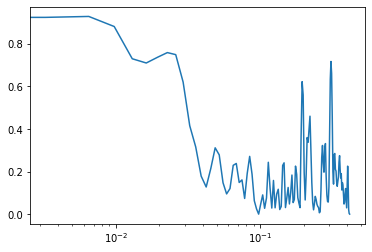

In [70]:
fcalc, coh_calc = sps.coherence(lidardat.ua-np.mean(lidardat.ua), 
                                lidardat.ub-np.mean(lidardat.ub), 
                                fs=fsamp,
                                nperseg=128,
                                nfft=256
                               )

plt.semilogx(fcalc, coh_calc)

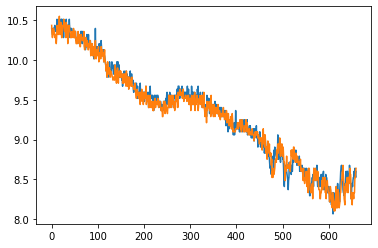

In [39]:
plt.plot(lidardat.ua)
plt.plot(lidardat.ub)

# Initial guesses for coefficient values
from 3_08_theoretical_lidar_coherence.ipynb

In [55]:
a1=8.4
a2=0.05
b1=0.25
b2=1.24

sigma = 0.71
L = 550

a = a1*sigma/U + a2
b = b1*L**-b2

print(a,b)

0.6894147147324338 9.997473777697821e-05


In [ ]:
# initial values
p0 = [a,b]

# limit fitting to a maximum frequency
max_fit_f = 0.05 # Hz

# find corresponding index in frequency vector
max_fit_ind = np.argmin(np.abs(fcalc - max_fit_f))

# least-squares fit up to max frequency
popt, pcov = sp.optimize.leastsq(residual, 
                                 p0, 
                                 args=(fcalc[:max_fit_ind], 
                                       coh_calc[:max_fit_ind]),
                                )

# Display optimal parameter values
print(popt)

# calculate fit coherence
fit_coh = lidar_coh(fvec, *popt)

plt.semilogx(fcalc, coh_calc, 'r',label='Measured Coh.')
plt.semilogx(fcalc,coh_fit(fcalc, dl, popt[0], popt[1]),'k--',label='Long. Coh.')
plt.semilogx(fvec, fit_coh,label='Modeled lidar Coh.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence [-]')
plt.legend()

plt.tight_layout()

## Try out different parameters

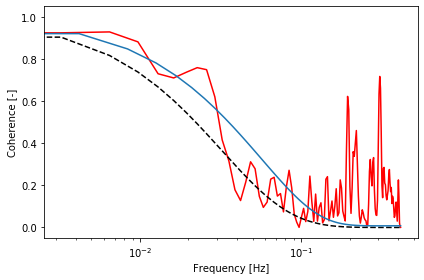

In [87]:
ag = .8*1.01120609e+01
bg = .004*3.63870145e-04

# calculate fit coherence
fit_coh = lidar_coh(fvec, ag, bg)

plt.semilogx(fcalc, coh_calc, 'r')
plt.semilogx(fcalc,coh_fit(fcalc, dl, ag, bg),'k--')
plt.semilogx(fvec, fit_coh)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence [-]')

plt.tight_layout()